In [ ]:
!gdown "13ZkrYeq_tZW_yTGzBYh-nHScsLk8nWa8"

Downloading...
From: https://drive.google.com/uc?id=13ZkrYeq_tZW_yTGzBYh-nHScsLk8nWa8
To: /content/train.csv
100% 29.8M/29.8M [00:00<00:00, 181MB/s] 


In [ ]:
!pip install sentence-transformers > /dev/null

In [ ]:
import json
import nltk
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
from sentence_transformers.evaluation import (
    EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator
)
from sentence_transformers import SentenceTransformer, InputExample, util, losses

In [ ]:
from models import Transformer
from spp import tokenize, SentenceProcessingPipeline
from utils import clear, word_frequency, freq_to_set, get_unique_values
from tools import compute_v2, validate_v2, benchmark_v2_core, benchmark_v2
from ranking_metrics import get_sims, get_relatives, precision_at_k, average_precision_at_k, mean_average_precision_at_k

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")
None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class CompanyNamesDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row["is_duplicate"]
        name_1, name_2 = row["name_1"], row["name_2"]
        return InputExample(texts=[name_1, name_2], label=float(label))
    def __len__(self):
        return len(self.data.index)

In [ ]:
df = pd.read_csv("train.csv")
dfc = clear(df)
dfc

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [ ]:
dfc[dfc["is_duplicate"] == 1]

,pair_id,name_1,name_2,is_duplicate
161,162,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,1
603,604,Pirelli Neumaticos S.A.I.C.,"Pirelli Tyre Co., Ltd.",1
835,836,Brenntag Australia (Pty) Ltd.,Brenntag Group,1
1328,1329,"PAUL BAUDER GMBH & CO KG, BOCHUM PLANT",Paul Bauder ag,1
1562,1563,TOTAL CESKA REPUBLIKA s.r.o.,TOTAL FRANCE (ARNAY LE DUC),1
...,...,...,...,...
496075,496076,Bridgestone De Mexico S.A. De C.V.,Bridgestone De Costa Rica S.A.,1
496237,496238,Bridgestone Stargard Sp Zoo,Bridgestone International Group,1
496760,496761,Arlanxeo International Group,Arlanxeo Corp.,1
497015,497016,Brenntag Peru S.A.C.,Brenntag Chile Comercial E Industrial Ltda,1


In [ ]:
len(dfc[dfc["is_duplicate"] == 1]["name_1"]), len(dfc[dfc["is_duplicate"] == 1]["name_1"].unique())

(3425, 814)

In [ ]:
train_data, test_data = train_test_split(dfc, test_size=0.2)
len(train_data), len(test_data)

(391000, 97751)

In [ ]:
train_dataset = CompanyNamesDataset(train_data)
test_dataset = CompanyNamesDataset(test_data)

In [ ]:
def get_items_weights(dfc):
    labels = dfc["is_duplicate"]
    y = labels.value_counts().to_numpy()
    class_weights = len(dfc) / y
    item_weights = [class_weights[l] for l in labels]
    return item_weights

In [ ]:
opt = {
    "epochs": 1,
    "batch_size": 32,
    "size": int(len(train_dataset) * 0.1),
}
opt["evaluation_steps"] =  int(opt["size"] / opt["batch_size"] * 0.15)
train_item_weights = get_items_weights(train_data)
wrs = WeightedRandomSampler(train_item_weights, opt["size"], replacement=True)
train_dataloader = DataLoader(
    train_dataset, sampler=wrs, batch_size=opt["batch_size"], pin_memory=True
)
opt["size"] / opt["batch_size"], opt["evaluation_steps"]

(1221.875, 183)

In [ ]:
train_model = SentenceTransformer('all-MiniLM-L6-v2')
train_loss = losses.CosineSimilarityLoss(train_model)

In [ ]:
a = np.array([(*item.texts, item.label) for item in test_dataset])
sentences1, sentences2, scores = a[:, 0], a[:, 1], a[:, 2].astype(float).astype(int)
evaluator = BinaryClassificationEvaluator(
    list(sentences1), list(sentences2), list(scores), 
    show_progress_bar=True
)

In [ ]:
class Callback:
    def __init__(self):
        self.best_current_score = 0
    def __call__(self, score, epoch, steps):
        if score > self.best_current_score:
            self.best_current_score = score
        print(score, epoch, steps)

In [ ]:
callback = Callback()

In [ ]:
train_model.fit(
    train_objectives=[(train_dataloader, train_loss)], callback=callback,
    epochs=opt["epochs"], evaluator=evaluator, 
    evaluation_steps=opt["evaluation_steps"]
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1222 [00:00<?, ?it/s]

Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.25973941173806603 0 183


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.5365419869754047 0 366


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.7070850068972192 0 549


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.7441664179120224 0 732


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.7703502994090126 0 915


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.8122222571468966 0 1098


Batches:   0%|          | 0/528 [00:00<?, ?it/s]

0.8344482200307631 0 -1


In [ ]:
train_model_test = Transformer(train_model)

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.975, 0.99]

Max f-score: 0.772948063270644


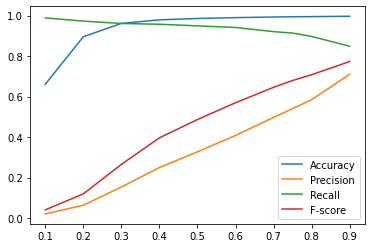

In [ ]:
benchmark_v2_core(dfc, train_model_test, 0, thresholds, remove_punkt=False)

Max f-score: 0.8393139520739569


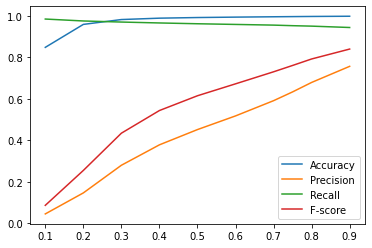

In [ ]:
benchmark_v2_core(test_data, train_model_test, 0, thresholds, 
                  remove_punkt=False, default_stopwords=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/sbert"

In [ ]:
best_score = 0
try:
    with open(f"{path}/score.txt") as file:
        best_score = float(file.read())
except:
    pass
best_score

0.8344482200307631

In [ ]:
if callback.best_current_score > best_score:
    train_model.save(f"{path}/model")
    with open(f"{path}/opt.json", "w") as file:
        file.write(json.dumps(opt, indent=4))
    with open(f"{path}/score.txt", "w") as file:
        file.write(str(callback.best_current_score))

In [ ]:
model = SentenceTransformer.load(f"{path}/model")
trans = Transformer(model)

Max f-score: 0.8815965711224217
Accuracy   : 0.9982242541968065
Precision  : 0.864233193277311
Recall     : 0.8996719518862767


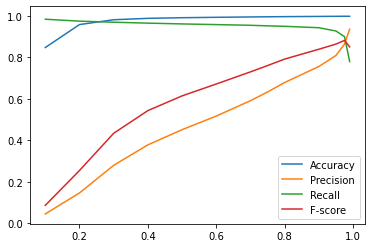

In [ ]:
benchmark_v2_core(dfc, trans, 0, thresholds, remove_punkt=False)

Max f-score: 0.8814467515070328
Accuracy   : 0.9982222454345857
Precision  : 0.8641975308641975
Recall     : 0.8993985784581738


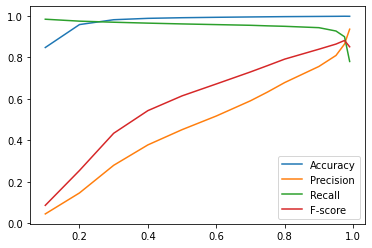

In [ ]:
benchmark_v2_core(test_data, trans, 0, thresholds, 
                  remove_punkt=False, default_stopwords=False)

In [ ]:
spp = SentenceProcessingPipeline(remove_punkt=False, default_stopwords=False)
names_unique = get_unique_values(dfc, names=["name_1", "name_2"])
trans.cache([spp(name) for name in names_unique])
s2v = {name:trans.encode(spp(name)) for name in names_unique}
dfn = pd.DataFrame(data={"vector":s2v})

In [ ]:
dfn = pd.DataFrame(data={"vector":s2v})

In [ ]:
mAP = mean_average_precision_at_k(dfc, dfn)
mAP

17676/17676


0.02689616806215586

In [ ]:
dfcd = dfc[dfc["is_duplicate"] == 1]
names_unique_d = get_unique_values(dfcd, names=["name_1", "name_2"])
s2vd = {name:trans.encode(spp(name)) for name in names_unique}
dfnd = pd.DataFrame(data={"vector":s2vd})

In [ ]:
mAPd = mean_average_precision_at_k(dfcd, dfnd)
mAPd

1101/1101


0.4318044202240388